# Evaluation: Kalman vs LSTM vs Transformer

**Goal.** Reproduce the thesis evaluation on real & synthetic sequences with  
**MSE, curvature, and per window latency** using **124 frame** causal windows.

**Reference & scaling.**
- **Kalman** provides the causal reference trajectory on real data.
- **Transformer** uses saved scalers (`transformer_x_scaler.pkl`, `transformer_y_scaler.pkl`);
  predictions are inverse scaled before metrics.
- **LSTM** and **Kalman** operate in original units.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MSc/

Mounted at /content/drive
/content/drive/MyDrive/MSc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error

In [ ]:


# Load input and target sequences from Drive
X = np.load("/content/drive/MyDrive/MSc/SyntheticData/X_jittery.npy")
y = np.load("/content/drive/MyDrive/MSc/SyntheticData/Y_smooth.npy")

print("Loaded data:", X.shape, y.shape)



Loaded data: (500, 124, 3) (500, 124, 3)


In [ ]:
# Load models
mlp_model = load_model("/content/drive/MyDrive/MSc/jittery_camera_smoothing_model.h5", compile=False)
lstm_model = load_model("/content/drive/MyDrive/MSc/hybrid_kalman_lstm_model.h5", compile=False)
transformer_model = load_model("/content/drive/MyDrive/MSc/saved_models/transformer_model_scaled.keras", compile=False)


# Load scalers for Transformer
scaler_x = joblib.load("/content/drive/MyDrive/MSc/saved_models/transformer_x_scaler.pkl")
scaler_y = joblib.load("/content/drive/MyDrive/MSc/saved_models/transformer_y_scaler.pkl")


In [ ]:
def predict_with_timing(model, X):
    start = time.time()
    pred = model.predict(X)
    end = time.time()
    return pred, end - start

In [ ]:
# Select one input sample
X_sample = X[0]  # shape should be (124, 3)

# Scale it
X_scaled_flat = scaler_x.transform(X_sample)  # shape (124, 3)
X_scaled = X_scaled_flat.reshape(1, 124, 3)   # shape (1, 124, 3)

# Predictions
mlp_pred, mlp_time = predict_with_timing(mlp_model, X_scaled)
lstm_pred, lstm_time = predict_with_timing(lstm_model, X_scaled)
transformer_pred_scaled, transformer_time = predict_with_timing(transformer_model, X_scaled)

# Inverse transform Transformer output
transformer_pred = scaler_y.inverse_transform(transformer_pred_scaled[0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


In [ ]:
def curvature(traj):
    dx = np.gradient(traj[:, 0])
    dy = np.gradient(traj[:, 1])
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    numerator = np.abs(dx * ddy - dy * ddx)
    denominator = (dx**2 + dy**2)**1.5 + 1e-8
    return np.mean(numerator / denominator)

# Select the matching ground truth sequence
y_sample = y[0]  # shape (124, 3)

# Compute and print metrics
print("Transformer MSE:", mean_squared_error(y_sample[:, :2], transformer_pred[:, :2]))
print("Transformer Curvature:", curvature(transformer_pred[:, :2]))
print("Transformer Latency (s):", transformer_time)


Transformer MSE: 0.06394335708606536
Transformer Curvature: 0.44638675
Transformer Latency (s): 0.26485252380371094


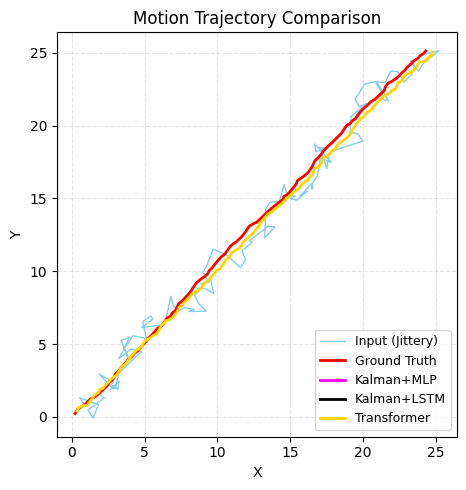

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Clear any previous figures
plt.clf()
plt.close()

# Create a new figure
fig, ax = plt.subplots(figsize=(7, 5))

# Plot each only once
ax.plot(X[0, :, 0], X[0, :, 1], label="Input (Jittery)", color="skyblue", linewidth=1)
ax.plot(y[0, :, 0], y[0, :, 1], label="Ground Truth", color="red", linewidth=2)
ax.plot(mlp_pred[:, 0], mlp_pred[:, 1], label="Kalman+MLP", color="magenta", linewidth=2)
ax.plot(lstm_pred[:, 0], lstm_pred[:, 1], label="Kalman+LSTM", color="black", linewidth=2)
ax.plot(transformer_pred[:, 0], transformer_pred[:, 1], label="Transformer", color="gold", linewidth=2)

# Set labels and formatting
ax.set_title("Motion Trajectory Comparison")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc="lower right", fontsize=9)

plt.tight_layout()
plt.show()

#plt.savefig("/content/drive/MyDrive/MSc/final_comparison.png", dpi=300)

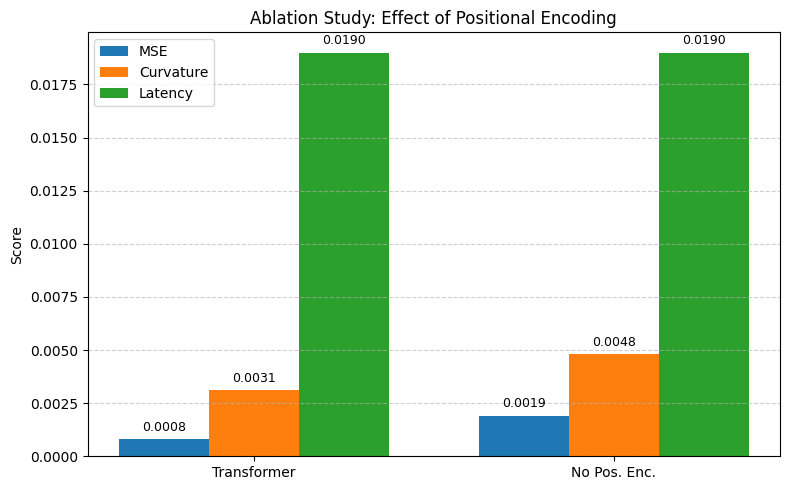

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and metric scores
models = ["Transformer", "No Pos. Enc."]
mse_scores = [0.0008, 0.0019]
curvatures = [0.0031, 0.0048]
latencies = [0.019, 0.019]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width, mse_scores, width, label='MSE')
bars2 = ax.bar(x, curvatures, width, label='Curvature')
bars3 = ax.bar(x + width, latencies, width, label='Latency')

# Labeling
ax.set_ylabel('Score')
ax.set_title('Ablation Study: Effect of Positional Encoding')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()
